# Calculating Climate Indices Using Bootstrapped Thresholds

Rather than using absolute temperature as a health indicator it can be more useful to instead consider various climate indices. 

This notebook describes how to calculate TX90p, TN90p, WSDI and CSDI indexes. Described in more detail at: https://www.climdex.org/learn/indices/#index-TN90p

In [1]:
import xarray as xr
import fsspec
import intake
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import pandas as pd


ERROR 1: PROJ: proj_create_from_database: Open of /share/apps/anaconda3-2022.05/envs/pangeo/share/proj failed


In [2]:
#silence warning when dividing by 0 as I am using this as a masking technique. not great coding practice but effective... 
import warnings
warnings.filterwarnings('ignore')

This notebook considers UTCI from ERA5 heat, but can be repurposed to consider absolute temperature from ERA5 or ERA5-land.

Please see the notebook titled: 01_working_with_bootstrapped_thresholds.ipynb. For more details on the threshold data.

In [64]:
fs = fsspec.filesystem("")
files = fs.glob('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/*_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc')
files

['/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/MRT_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/MRTmax_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/MRTmin_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCI_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImax_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc',
 '/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImin_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc']

In [4]:
ds_thresh = xr.open_dataset('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImax_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc')
ds_thresh

<xarray.Dataset>
Dimensions:               (lat: 297, lon: 289, quantile: 8, dayofyear: 365)
Coordinates:
  * lat                   (lat) float64 38.0 37.75 37.5 ... -35.5 -35.75 -36.0
  * lon                   (lon) float64 -20.0 -19.75 -19.5 ... 51.5 51.75 52.0
  * quantile              (quantile) float64 0.01 0.02 0.05 ... 0.95 0.98 0.99
  * dayofyear             (dayofyear) int64 1 2 3 4 5 6 ... 361 362 363 364 365
Data variables:
    bs_quantile_median    (dayofyear, quantile, lat, lon) float64 ...
    bs_quantile_variance  (dayofyear, quantile, lat, lon) float64 ...

# TX90p

Percentage of days when TX > 90th percentile

Let TXij be the daily maximum temperature on day i in period j and let TXin90 be the calendar day 90th percentile centred on a 5-day window for the base period 1961-1990. The percentage of time for the base period is determined where TXij > TXin90. To avoid possible inhomogeneity across the in-base and out-base periods, the calculation for the base period (1961-1990) requires the use of a bootstrap processure. Details are described in Zhang et al. (2005).

In [5]:
catalog = intake.open_catalog(Path(Path.home(),'heat_center/data/climate/reanalysis/intake/reanalysis.yaml'))
ds_heat = catalog['ERA5-HEAT']['day']['UTCImax'].to_dask()
ds_heat = ds_heat.sel(lat = list(ds_thresh.lat.values), lon = list(ds_thresh.lon.values)).UTCImax #subselect same africa only domain
ds_heat = ds_heat.convert_calendar('noleap') # remove leap year conundrum 

In [6]:
# apply only allows for one input arg, hence using kwargs to define threshold data
def calc_TX90p_yearly(ds_year, **kwargs):
    ds_thresh = kwargs.pop('ds_thresh')
    x = (ds_year.groupby('time.dayofyear') >= ds_thresh.sel(quantile = 0.9).bs_quantile_median) #where the threshold is exceeded
    x = (x/x).sum(dim = 'time', skipna = True) #set all non NAN values to zero, all NANs remain NAN. 
    x = (x/len(ds_year.time))*100 #get as percentage
    return x

In [7]:
TX90p = ds_heat.groupby('time.year').map(calc_TX90p_yearly, ds_thresh = ds_thresh)

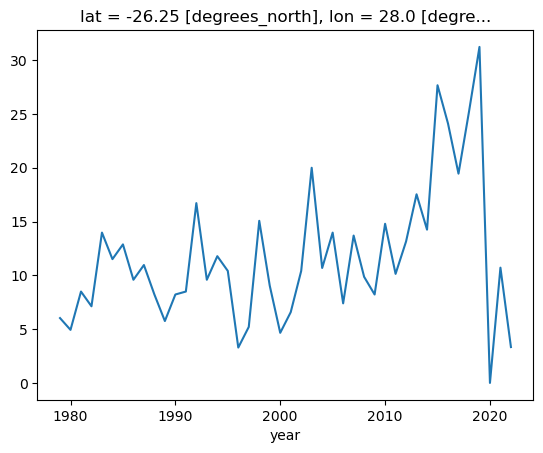

In [8]:
lat_, lon_ = -26.198513, 28.029066 #JHB

TX90p.sel(lat = lat_, lon = lon_, method = 'nearest').plot()

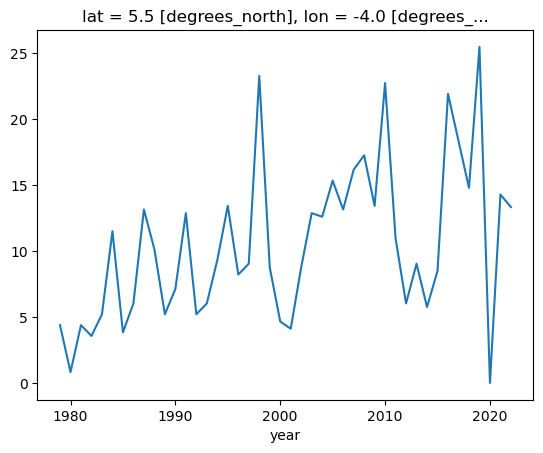

In [9]:
lat_, lon_ = 5.383200, -4.038460 #ABJ

TX90p.sel(lat = lat_, lon = lon_, method = 'nearest').plot()

# TN90p

Percentage of days when TN > 90th percentile

Let TNij be the daily minimum temperature on day i in period j and let TNin90 be the calendar day 90th percentile centred on a 5-day window for the base period 1961-1990. The percentage of time for the base period is determined where TNij > TNin90. To avoid possible inhomogeneity across the in-base and out-base periods, the calculation for the base period (1961-1990) requires the use of a bootstrap processure. Details are described in Zhang et al. (2005)

In [10]:
ds_thresh = xr.open_dataset('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImin_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc')
ds_heat = catalog['ERA5-HEAT']['day']['UTCImin'].to_dask()
ds_heat = ds_heat.sel(lat = list(ds_thresh.lat.values), lon = list(ds_thresh.lon.values)).UTCImin #subselect same africa only domain
ds_heat = ds_heat.convert_calendar('noleap') # remove leap year conundrum 

In [11]:
TN90p = ds_heat.groupby('time.year').map(calc_TX90p_yearly, ds_thresh = ds_thresh) # the function is identical to TX90p

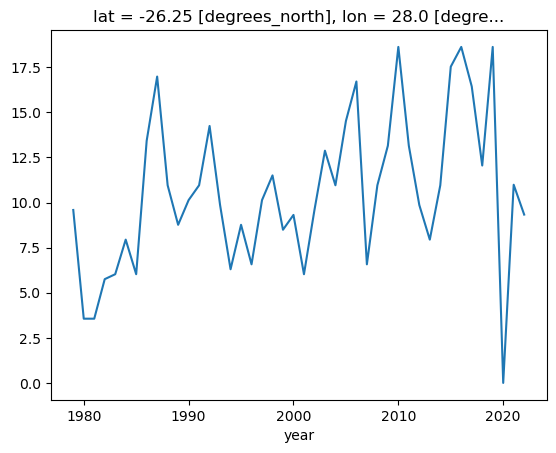

In [12]:
lat_, lon_ = -26.198513, 28.029066 #JHB

TN90p.sel(lat = lat_, lon = lon_, method = 'nearest').plot()

# WSDI

Warm spell duration index: annual count of days with at least 6 consecutive days when TX > 90th percentile

Let TXij be the daily maximum temperature on day i in period j and let TXin90 be the calendar day 90th percentile centred on a 5-day window for the base period 1961-1990. Then the number of days per period is summed where, in intervals of at least 6 consecutive days, TXij > TXin90.

In [13]:
import pandas as pd

In [14]:
ds_thresh = xr.open_dataset('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImax_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc')

ds_heat = catalog['ERA5-HEAT']['day']['UTCImax'].to_dask()
ds_heat = ds_heat.sel(lat = list(ds_thresh.lat.values), lon = list(ds_thresh.lon.values)).UTCImax #subselect same africa only domain
ds_heat = ds_heat.convert_calendar('noleap') # remove leap year conundrum 

I am not entirely confident on how to interpret WSDI, so I have provided a number of different options:

In [55]:
#number of heat spells longer than 6 days 
def return_no_events(x):
    sparse_df = pd.Series(pd.arrays.SparseArray(x))
    blenghts = sparse_df.values.sp_index.to_block_index().blengths
    return (blenghts >= 6).sum()

#mean length of heat spells longer than 6 days 
def return_mean_duration(x):
    sparse_df = pd.Series(pd.arrays.SparseArray(x))
    blenghts = sparse_df.values.sp_index.to_block_index().blengths
    return blenghts[blenghts>6].mean()

#total number of days during heat spells longer than 6 days 
def return_total_no_days(x):
    sparse_df = pd.Series(pd.arrays.SparseArray(x))
    blenghts = sparse_df.values.sp_index.to_block_index().blengths
    return (blenghts[blenghts>6]).sum()   

def calc_heat_spells(ds_year, **kwargs):
    ds_thresh = kwargs.pop('ds_thresh')
    quantile = kwargs.pop('quantile')
    func = kwargs.pop('function')
    ds_thresh_sel = ds_thresh.sel(lat = ds_year.lat.values, lon = ds_year.lon.values) #subselect same africa only domain
    x = (ds_year.groupby('time.dayofyear') >= ds_thresh_sel.sel(quantile = quantile).bs_quantile_median).fillna(0) #where the threshold is exceeded
    x = (x/x) #set all non NAN values to 1, and all NANs to 0. 
    if len(ds_year.shape) == 3:
        x = x.stack(space = ['lat','lon'])
    x = x.load() #dask not supported by pandas sparse
    x = xr.apply_ufunc(func, x, input_core_dims=[['time']], vectorize =True)
    if 'space' in list(x.coords):
        x = x.unstack('space')
    return x

Number of heat spells longer than 6 days 

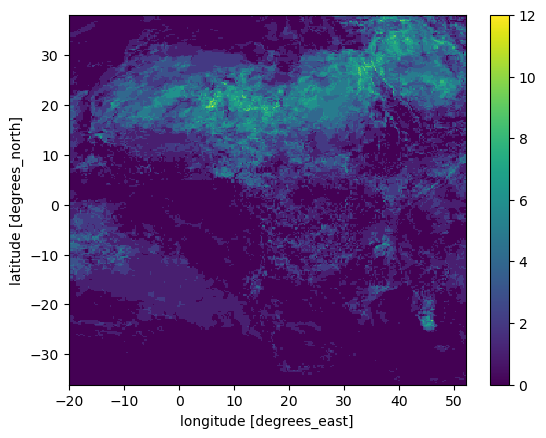

In [56]:
calc_heat_spells(ds_heat.sel(time = '2010'), function = return_no_events, ds_thresh = ds_thresh, quantile = 0.9).plot()

Mean length of heat spells longer than 6 days

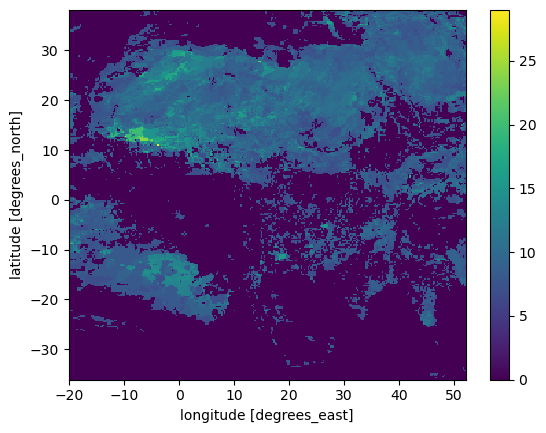

In [32]:
calc_heat_spells(ds_heat.sel(time = '2010'), function = return_mean_duration, ds_thresh = ds_thresh, quantile = 0.9).fillna(0).plot()

Total number of days during heat spells longer than 6 days

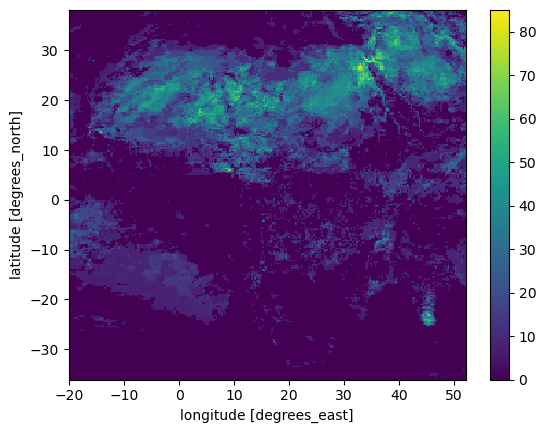

In [33]:
calc_heat_spells(ds_heat.sel(time = '2010'), function = return_total_no_days, ds_thresh = ds_thresh, quantile = 0.9).plot()

And to calculate the total number of heat wave days in JHB:

CPU times: user 2min 15s, sys: 30.4 s, total: 2min 46s
Wall time: 3min 2s


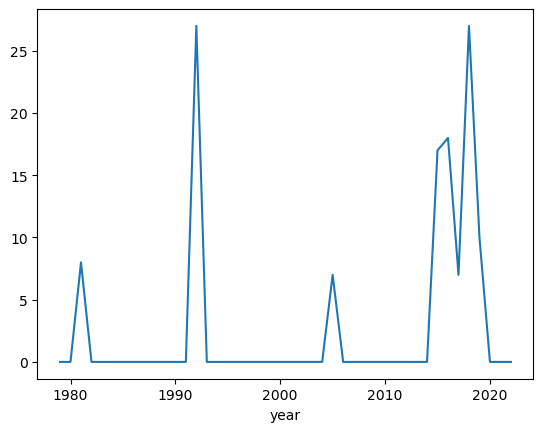

In [52]:
%%time
lat_, lon_ = -26.198513, 28.029066 #JHB
ds_ = ds_heat.sel(lat = lat_, lon = lon_, method = 'nearest')
ds_.groupby('time.year').map(calc_heat_spells, function = return_total_no_days, ds_thresh = ds_thresh, quantile = 0.9).plot()

# CSDI

Cold spell duration index: annual count of days with at least 6 consecutive days when TN < 10th percentile

Let TNij be the daily maximum temperature on day i in period j and let TNin10 be the calendar day 10th percentile centred on a 5-day window for the base period 1961-1990. Then the number of days per period is summed where, in intervals of at least 6 consecutive days, TNij < TNin10.

In [58]:
ds_thresh = xr.open_dataset('/terra/data/reanalysis/global/reanalysis/ECMWF/ERA5-HEAT/clim/native/UTCImin_bs_perc_ECMWF_ERA5-HEAT_19810101-20101231.nc')

ds_heat = catalog['ERA5-HEAT']['day']['UTCImin'].to_dask()
ds_heat = ds_heat.sel(lat = list(ds_thresh.lat.values), lon = list(ds_thresh.lon.values)).UTCImin #subselect same africa only domain
ds_heat = ds_heat.convert_calendar('noleap') # remove leap year conundrum 

In [60]:
def calc_cold_spells(ds_year, **kwargs):
    ds_thresh = kwargs.pop('ds_thresh')
    quantile = kwargs.pop('quantile')
    func = kwargs.pop('function')
    ds_thresh_sel = ds_thresh.sel(lat = ds_year.lat.values, lon = ds_year.lon.values) #subselect same africa only domain
    x = (ds_year.groupby('time.dayofyear') <= ds_thresh_sel.sel(quantile = quantile).bs_quantile_median).fillna(0) #where the threshold is exceeded
    x = (x/x) #set all non NAN values to 1, and all NANs to 0. 
    if len(ds_year.shape) == 3:
        x = x.stack(space = ['lat','lon'])
    x = x.load() #dask not supported by pandas sparse
    x = xr.apply_ufunc(func, x, input_core_dims=[['time']], vectorize =True)
    if 'space' in list(x.coords):
        x = x.unstack('space')
    return x

CPU times: user 2min 14s, sys: 29.9 s, total: 2min 44s
Wall time: 3min 2s


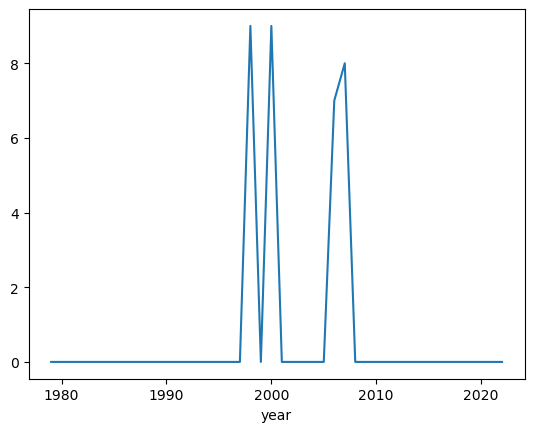

In [61]:
%%time
lat_, lon_ = -26.198513, 28.029066 #JHB
ds_ = ds_heat.sel(lat = lat_, lon = lon_, method = 'nearest')
ds_.groupby('time.year').map(calc_cold_spells, function = return_total_no_days, ds_thresh = ds_thresh, quantile = 0.1).plot()